# TensorFlow Receiver Operator Characteristic (ROC) curve and balancing of model classification

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc

# TensorFlow api model
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

2021-10-09 22:59:28.930243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Download data if not previously downloaded

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to calculate accuracy measurements

In [4]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_negatives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [5]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc
    

## Load data

In [6]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

Here we use the api-based method to set up a TensorFlow neural network. This method allows us to more flexibly define the inputs for each layer, rather than assuming there is a simple sequence as with the `Sequential` method.

We will put construction of the neural net into a separate function.

The neural net is a relatively simple network. The inputs are connected to two hidden layers (of 240 and 50 nodes) before being connected to two output nodes corresponding to each class (died and survived). It also contains some useful additions (batch normalisation and dropout) as described below.

The layers of the network are:

1) An input layer (which *does* need to be defined) 

2) A fully-connected (dense) layer.This is defined by the number of inputs (the number of input features) and the number of outputs. We will expand out feature data set up to 240 outputs. The output of the layer uses ReLU  (rectified linear unit) activation. ReLU activation is most common for the inner layers of a neural network. Negative input values are set to zero. Positive input values are left unchanged.

3) A batch normalisation layer. This is not usually used for small models, but can increase the speed of training for larger models. It is added here as an example of how to include it (in large models all dense layers would be followed by a batch normalisation layer). The layer definition includes the number of inputs to normalise.

4) A dropout layer. This layer randomly sets outputs from the preceding layer to zero during training (a different set of outputs is zeroed for each training iteration). This helps prevent over-fitting of the model to the training data. Typically between 0.1 and 0.3 outputs are set to zero (`p=0.1` means 10% of outputs are set to zero).

5) A second fully connected layer which reduces the network down to 50 nodes. This again uses ReLU activation and is followed by batch normalisation, and dropout layers.

7) A final fully connected linear layer of one nodes (more nodes could be used for more classes, in which case use `softmax` activation and `categorical_crossentropy` in the loss function).

The output of the net is the probability of surviving (usually a probability of >= 0.5 will be classes as 'survived').

In [7]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow
    K.clear_session()
       
    inputs = layers.Input(shape=number_features)
    dense_1 = layers.Dense(240, activation='relu')(inputs)
    norm_1 = layers.BatchNormalization()(dense_1)
    dropout_1 = layers.Dropout(0.25)(norm_1)
    dense_2 = layers.Dense(50, activation='relu')(dropout_1)
    outputs = layers.Dense(1, activation='sigmoid')(dense_2)
    
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    
    net.compile(loss='binary_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy'])
    
    return net

## Run the model with k-fold validation and ROC calculation

In [8]:
# Set up k-fold training/test splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X_np, y_np)

# Set up thresholds
thresholds = np.arange(0, 1.01, 0.01)

# Create arrays for overall results (rows=threshold, columns=k fold replicate)
results_accuracy = np.zeros((len(thresholds),number_of_splits))
results_precision = np.zeros((len(thresholds),number_of_splits))
results_recall = np.zeros((len(thresholds),number_of_splits))
results_f1 = np.zeros((len(thresholds),number_of_splits))
results_predicted_positive_rate = np.zeros((len(thresholds),number_of_splits))
results_observed_positive_rate = np.zeros((len(thresholds),number_of_splits))
results_true_positive_rate = np.zeros((len(thresholds),number_of_splits))
results_false_positive_rate = np.zeros((len(thresholds),number_of_splits))
results_auc = []

# Loop through the k-fold splits
loop_index = 0
for train_index, test_index in skf.split(X_np, y_np):
    
    # Create lists for k-fold results
    threshold_accuracy = []
    threshold_precision = []
    threshold_recall = []
    threshold_f1 = []
    threshold_predicted_positive_rate = []
    threshold_observed_positive_rate = []
    threshold_true_positive_rate = []
    threshold_false_positive_rate = []

    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    # Set up and fit model
    X_train_sc, X_test_sc = scale_data(X_train, X_test)
    
    # Define network
    number_features = X_train_sc.shape[1]
    model = make_net(number_features)
    
    ### Train model
    model.fit(X_train_sc,
             y_train,
             epochs=150,
             batch_size=512,
             verbose=0)

    
    # Get probability of non-survive and survive
    probability_survival = model.predict(X_test_sc)
    probability_survival = probability_survival.flatten()
    
    # Loop through increments in probability of survival
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get whether passengers survive using cutoff
        predicted_survived = probability_survival >= cutoff
        # Call accuracy measures function
        accuracy = calculate_accuracy(y_test, predicted_survived)
        # Add accuracy scores to lists
        threshold_accuracy.append(accuracy['accuracy'])
        threshold_precision.append(accuracy['precision'])
        threshold_recall.append(accuracy['recall'])
        threshold_f1.append(accuracy['f1'])
        threshold_predicted_positive_rate.append(
                accuracy['predicted_positive_rate'])
        threshold_observed_positive_rate.append(
                accuracy['observed_positive_rate'])
        threshold_true_positive_rate.append(accuracy['true_positive_rate'])
        threshold_false_positive_rate.append(accuracy['false_positive_rate'])
    
    # Add results to results arrays
    results_accuracy[:,loop_index] = threshold_accuracy
    results_precision[:, loop_index] = threshold_precision
    results_recall[:, loop_index] = threshold_recall
    results_f1[:, loop_index] = threshold_f1
    results_predicted_positive_rate[:, loop_index] = \
        threshold_predicted_positive_rate
    results_observed_positive_rate[:, loop_index] = \
        threshold_observed_positive_rate
    results_true_positive_rate[:, loop_index] = threshold_true_positive_rate
    results_false_positive_rate[:, loop_index] = threshold_false_positive_rate
    
    # Calculate ROC AUC
    roc_auc = auc(threshold_false_positive_rate, threshold_true_positive_rate)
    results_auc.append(roc_auc)
    
    # Increment loop index
    loop_index += 1
    

# Transfer summary results to dataframe
results = pd.DataFrame(thresholds, columns=['thresholds'])
results['accuracy'] = results_accuracy.mean(axis=1)
results['precision'] = results_precision.mean(axis=1)
results['recall'] = results_recall.mean(axis=1)
results['f1'] = results_f1.mean(axis=1)
results['predicted_positive_rate'] = \
    results_predicted_positive_rate.mean(axis=1)
results['observed_positive_rate'] = \
    results_observed_positive_rate.mean(axis=1)
results['true_positive_rate'] = results_true_positive_rate.mean(axis=1)
results['false_positive_rate'] = results_false_positive_rate.mean(axis=1)
results['roc_auc'] = np.mean(results_auc)

mean_auc = np.mean(results_auc)
mean_auc = np.round(mean_auc, 3)

2021-10-09 22:59:30.215274: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-09 22:59:30.216085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-09 22:59:31.844287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 22:59:31.844612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-10-09 22:59:31.844644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-09 22:59:31.845975: I tensorflow/stream_executor/platform

## Plot ROC curve

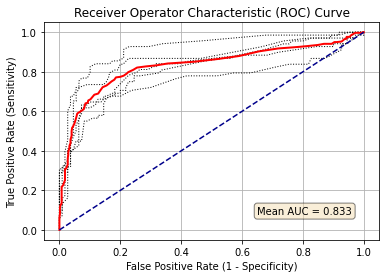

In [9]:
%matplotlib inline

for i in range(number_of_splits):
    plt.plot(results_false_positive_rate[:, i],
             results_true_positive_rate[:, i],
             color='black',
             linestyle=':',
             linewidth=1)
plt.plot(results_false_positive_rate.mean(axis=1),
         results_true_positive_rate.mean(axis=1),
         color='red',
         linestyle='-',
         linewidth=2)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operator Characteristic (ROC) Curve')
plt.grid(True)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = "Mean AUC = " + str(mean_auc)
plt.text(0.65, 0.08, text, bbox=props)
plt.show()

## Plot effects of changing classification probability threshold

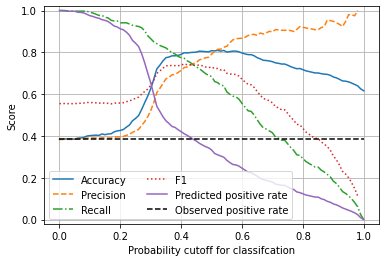

In [10]:
chart_x = results['thresholds']

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

plt.plot(chart_x, results['observed_positive_rate'],
         linestyle = '--',
         color='k',
         label = 'Observed positive rate')


plt.xlabel('Probability cutoff for classifcation')
plt.ylabel('Score')
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower left', ncol=2)
plt.grid(True)

plt.show()

## Observations

* Using the default values for probability cut-off, the TensorFlow model under-predicts the proportion of passengers who survive (the minority class).
* Without rebalancing of classes (under-sampling of the majority class, or over-sampling of the minority class) the model may be rebalanced by adjusting the probability threshold for classification (at the cost of a small reduction in overall accuracy).